In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import a_matrix_analysis_lib as matansys
import b_spin_representations as su2

In [2]:
N = 3
spin_ops = su2.one_body_spin_ops(N)
identity_op = spin_ops[0]
sx_list = spin_ops[1]; sy_list = spin_ops[2]; sz_list = spin_ops[3]

In [3]:
J = 1 
H = J * (sx_list[0]*sx_list[1] + sx_list[1]*sx_list[2] + sx_list[2]*sx_list[0])
H += J * (sy_list[0]*sy_list[1] + sy_list[1]*sy_list[2] + sy_list[2]*sy_list[0])
H += J * (sz_list[0]*sz_list[1] + sz_list[1]*sz_list[2] + sz_list[2]*sz_list[0])

In [4]:
def safe_expm_and_normalize(K, return_free_energy = True, tol = 1e-5):
    n_eig = sum(K.dims[0])
    if n_eig <= 16:
        e0 = max(K.eigenenergies())
    else:
        e0 = max(K.eigenenergies(sparse="True", sort = "high", eigvals = n_eig))
    sigma = (K-e0).expm()
    z = np.real(sigma.tr())
    sigma = sigma/z
    if return_free_energy: 
        f = -np.log(z) - e0;
    else:
        pass
    return sigma

In [5]:
random_no_list = [np.random.rand() for i in range(N)]

K = sum(random_no_list[m] * sx_list[m] * sx_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sy_list[m] * sy_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sz_list[m] * sz_list[(m+1) % N] for m in range(N))
rho0 = safe_expm_and_normalize(K, False)

In [14]:
basis = sx_list 
trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))
sigma0 = safe_expm_and_normalize(trial_K, False)

coeff_list1 = [qutip.expect(sigma0, op) for op in basis]
K1 = sum(zeta1 * op for zeta1, op in zip(coeff_list1, basis))
sigma1 = safe_expm_and_normalize(K1, False)

print(linalg.norm(rho0 - sigma1))
print(linalg.norm(rho0 - sigma0))

0.1908517141103419
0.2763714463310511


In [19]:
basis_of_basis = [sx_list, sy_list, sz_list]
trial_Ks = [sum(zeta * op for zeta, op in zip(random_no_list, basis)) for basis in basis_of_basis]
sigma0s = [safe_expm_and_normalize(K0, False) for K0 in trial_Ks]

mft_coefficients = []
for sigma0_i, basis_i in zip(sigma0s, basis_of_basis):
    local_list = [qutip.expect(sigma0_i, op) for op in basis_i]
    mft_coefficients.append(local_list)
    local_list = None

first_iteration_Ks = []
for mft_coefficients_i, basis_i in zip(mft_coefficients, basis_of_basis):
    local_K = sum(zeta_j * op_j for zeta_j, op_j in zip(mft_coefficients_i, basis_i))
    first_iteration_Ks.append(local_K)
    local_K = 0
    
first_iterations_mft_states = [safe_expm_and_normalize(K1, False) for K1 in first_iteration_Ks] 
initial_distances = [linalg.norm(rho0 - sigma0) for sigma0 in sigma0s]
first_iteration_distances = [linalg.norm(rho0 - sigma1) for sigma1 in first_iterations_mft_states]

In [20]:
initial_distances

[0.2507800319535709, 0.25078003195357096, 0.2507800319535709]

In [21]:
first_iteration_distances

[0.16023946168978892, 0.16023946168978892, 0.16023946168978892]

In [ ]:
### ERROR ACA

In [42]:
trial_Ks[1]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.4013647j  0.-0.2940203j  0.+0.j
  0.-0.47113643j 0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.4013647j  0.+0.j         0.+0.j         0.-0.2940203j
  0.+0.j         0.-0.47113643j 0.+0.j         0.+0.j        ]
 [0.+0.2940203j  0.+0.j         0.+0.j         0.-0.4013647j
  0.+0.j         0.+0.j         0.-0.47113643j 0.+0.j        ]
 [0.+0.j         0.+0.2940203j  0.+0.4013647j  0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.-0.47113643j]
 [0.+0.47113643j 0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.-0.4013647j  0.-0.2940203j  0.+0.j        ]
 [0.+0.j         0.+0.47113643j 0.+0.j         0.+0.j
  0.+0.4013647j  0.+0.j         0.+0.j         0.-0.2940203j ]
 [0.+0.j         0.+0.j         0.+0.47113643j 0.+0.j
  0.+0.2940203j  0.+0.j         0.+0.j         0.-0.4013647j ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.47113643j
  0

In [38]:
linalg.norm(trial_Ks[0] - trial_Ks[1])

2.7408351979994605

In [29]:
initial_distances

[0.2763714463310511, 0.2763714463310512, 0.2763714463310512]

In [30]:
first_iteration_distances

[0.18501328855051866, 0.18501328855051866, 0.1908517141103419]

In [7]:
def mean_field_state(rho0, basis, init_guesstimates, steps):
    
    trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))
    sigma0 = safe_expm_and_normalize(trial_K, False)
    mft_states = [sigma0]
    for i in range(1, steps):
        sigma_mft = mft_states[i-1]
        coeff_list_j = [qutip.expect(sigma_mft, op) for op in basis]
        K_j = sum(zeta_j * op for zeta_j, op in zip(coeff_list_j, basis))
        sigma_j = safe_expm_and_normalize(K_j, False)
        mft_states.append(sigma_j)
    
    return mft_states

In [8]:
mft_states = mean_field_state(rho0, basis, random_no_list, 10)
distances = [linalg.norm(rho0 - mftstate) for mftstate in mft_states]

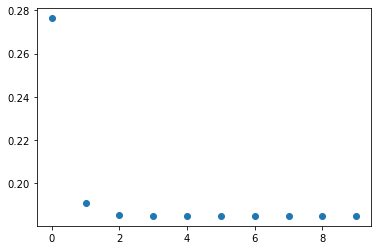

In [9]:
plt.scatter([i for i in range(10)], distances)

In [ ]:
1. Que pasa si uso un mal estado?
2. Que pasa si uso coeficientes no aleatorios? Lejos y cercanos
3. Como se ve en la metrica KMB y la rel entr
4. Donde entra en juego las bases jerárquicas?
5. Que pasa si uso otros estados??